# Walmart Sales and Revenue Forecasting  

## **Objective**  
The primary goal of this project is to forecast sales for Walmart stores using historical data. Accurate forecasting helps Walmart optimize inventory, manage resources effectively, and improve overall operational efficiency.

## **Dataset Description**  
The project uses the Walmart Sales Forecast dataset, which contains the following data:  
- **Store**: Store ID.  
- **Dept**: Department ID within the store.  
- **Date**: Weekly sales date.  
- **Weekly_Sales**: Sales revenue for the given department and store.  
- **IsHoliday**: Boolean flag for whether the week includes a holiday.  
- Additional economic indicators like temperature, CPI, unemployment rate, and fuel prices.  

## **Tools and Techniques**  
- **Tools**: Python (Jupyter Notebook), Power BI for visualization.  
- **Libraries**: pandas, numpy, matplotlib, seaborn, sklearn, etc.  
- **Techniques**:  
  - Data preprocessing and cleaning  
  - Exploratory Data Analysis (EDA)  
  - Feature engineering  
  - Machine Learning for forecasting (Linear Regression and Decision Tree Regressor)  

## **Project Outline**  
1. Data loading and initial exploration
2. Data cleaning  
3. Exploratory Data Analysis (EDA)  
4. Feature engineering  
5. Model training and evaluation  
6. Results visualization and analysis  


## **1. Data Loading and Initial Exploration**  
The datasets include historical sales data and economic indicators. These are loaded and merged to create a unified dataset for analysis.

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

features = pd.read_csv('Datasets/features.csv')
stores = pd.read_csv('Datasets/stores.csv')
train = pd.read_csv('Datasets/train.csv')
test = pd.read_csv('Datasets/test.csv')

# Merge Features with Stores
features_stores = features.merge(stores, on='Store', how='left')

# Merge the result with Train
train_combined = train.merge(features_stores, on=['Store', 'Date'], how='left')

# Merge Features and Stores with Test
test_combined = test.merge(features_stores, on=['Store', 'Date'], how='left')

print("Training Data:")
print(f"\n{train_combined.head()}")
print("\nTesting Data:")
print(f"\n{test_combined.head()}")


Training Data:

   Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
0      1     1  2010-02-05      24924.50        False        42.31   
1      1     1  2010-02-12      46039.49         True        38.51   
2      1     1  2010-02-19      41595.55        False        39.93   
3      1     1  2010-02-26      19403.54        False        46.63   
4      1     1  2010-03-05      21827.90        False        46.50   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.548        NaN        NaN        NaN        NaN        NaN   
2       2.514        NaN        NaN        NaN        NaN        NaN   
3       2.561        NaN        NaN        NaN        NaN        NaN   
4       2.625        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  IsHoliday_y Type    Size  
0  211.096358         8.106        False    A  151315  
1  211.242170     

## **2. Data Cleaning**  
Steps in the cleaning process:  
1. Checked for missing values in the dataset.  
2. Filled missing values in economic indicators (e.g., MarkDown columns).  
3. Converted the `Date` column to a datetime object.  
4. Verified data consistency and types for model input.

In [47]:
# Check missing values
print("Missing values in Train Combined:")
print(f"\n{train_combined.isnull().sum()}")

# Drop duplicate IsHoliday column
train_combined = train_combined.drop(columns=['IsHoliday_y'])
test_combined = test_combined.drop(columns=['IsHoliday_y'])

# Rename the remaining IsHoliday column
train_combined.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
test_combined.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

# Convert Date to datetime format
train_combined['Date'] = pd.to_datetime(train_combined['Date'])
test_combined['Date'] = pd.to_datetime(test_combined['Date'])

# Extract time-based features (Year, Month, Week)
train_combined['Year'] = train_combined['Date'].dt.year
train_combined['Month'] = train_combined['Date'].dt.month
train_combined['Week'] = train_combined['Date'].dt.isocalendar().week

test_combined['Year'] = test_combined['Date'].dt.year
test_combined['Month'] = test_combined['Date'].dt.month
test_combined['Week'] = test_combined['Date'].dt.isocalendar().week

# Fill missing MarkDown values with 0 (Assume missing means no markdowns)
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train_combined[markdown_columns] = train_combined[markdown_columns].fillna(0)
test_combined[markdown_columns] = test_combined[markdown_columns].fillna(0)

# Confirm no missing values remain
print("\nMissing values after filling:")
print(f"\n{train_combined.isnull().sum()}")


Missing values in Train Combined:

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64

Missing values after filling:

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
dtype: int64


## **3. Exploratory Data Analysis (EDA)**  
In this section, we explore the dataset to understand patterns and trends in sales, identify outliers, and analyze relationships between features.

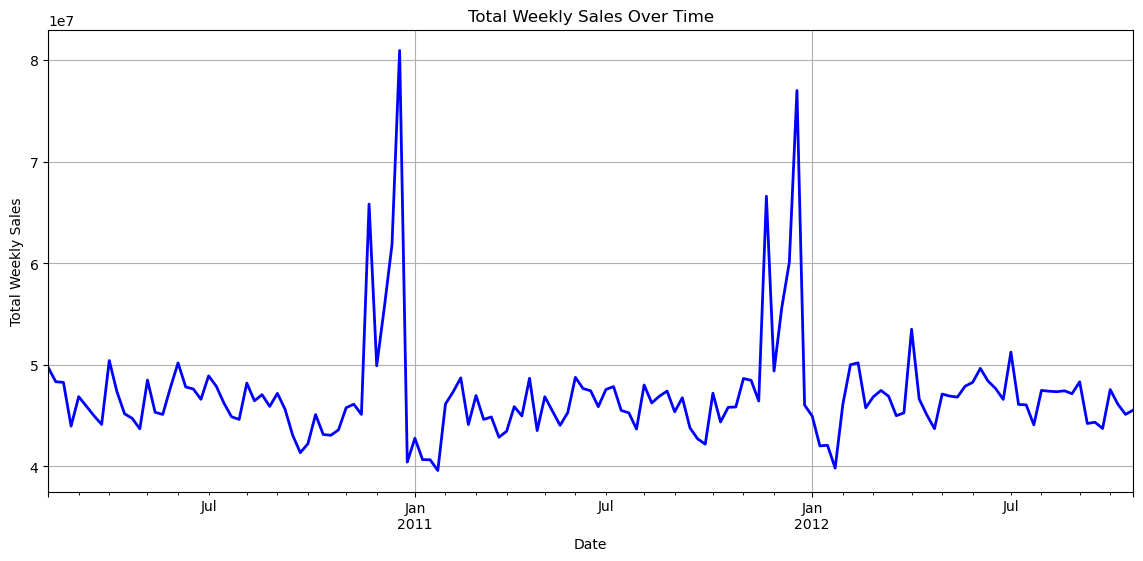

In [48]:
# Total Sales over time
sales_trend = train_combined.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(14, 6))
sales_trend.plot(color='blue', linewidth=2)
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.grid()
plt.show()

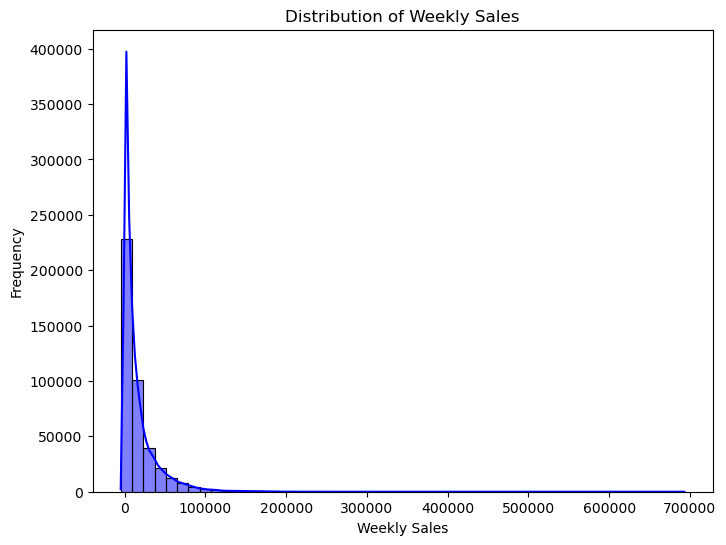

In [49]:
# Sales distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_combined['Weekly_Sales'], kde=True, color='blue', bins=50)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

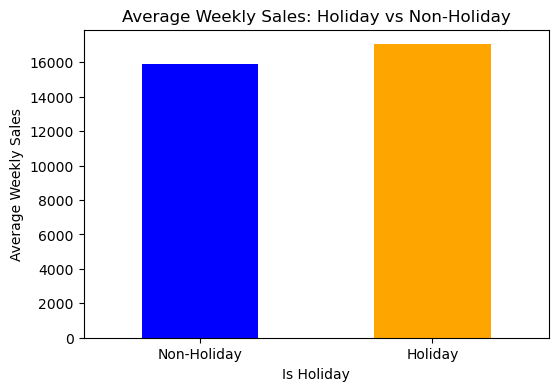

In [50]:
# Average sales during holidays vs. non-holidays
holiday_sales = train_combined.groupby('IsHoliday')['Weekly_Sales'].mean()

plt.figure(figsize=(6, 4))
holiday_sales.plot(kind='bar', color=['blue', 'orange'])
plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Average Weekly Sales')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()

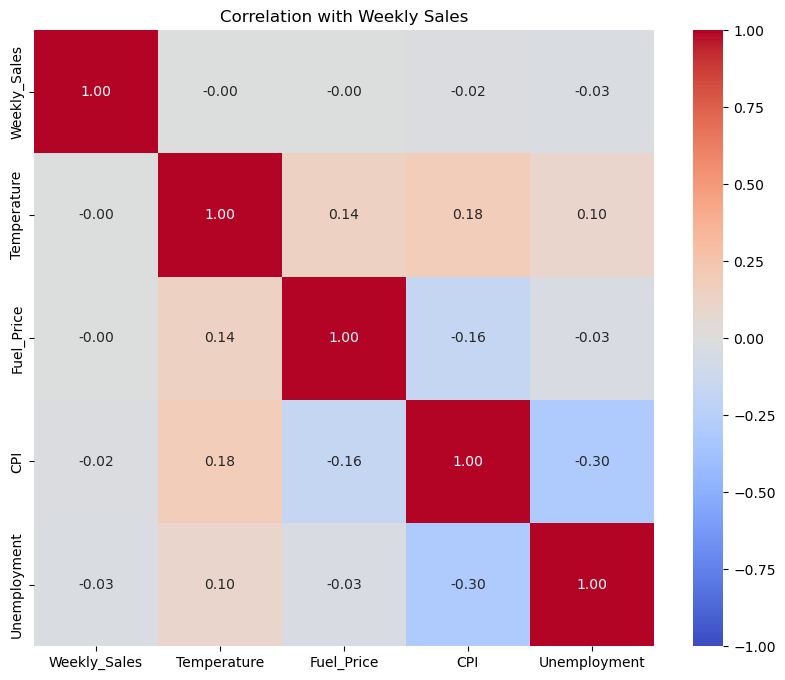

In [51]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation = train_combined[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation with Weekly Sales')
plt.show()

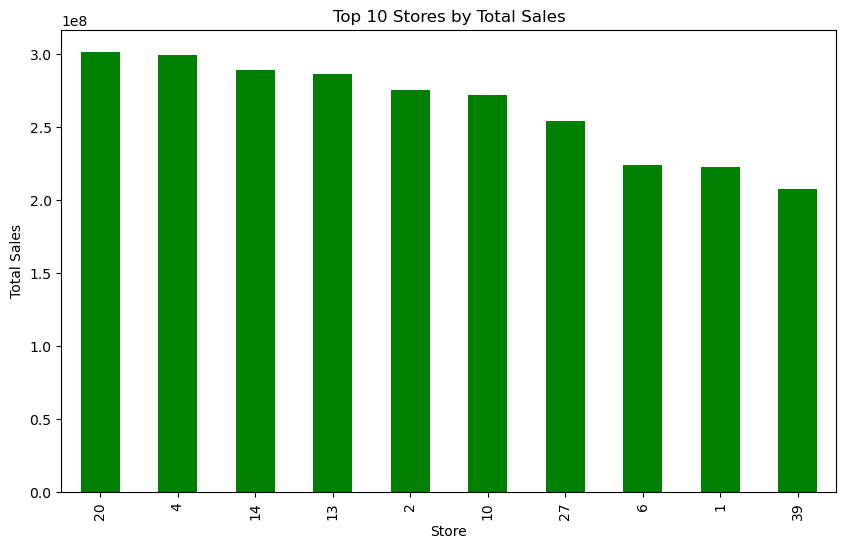

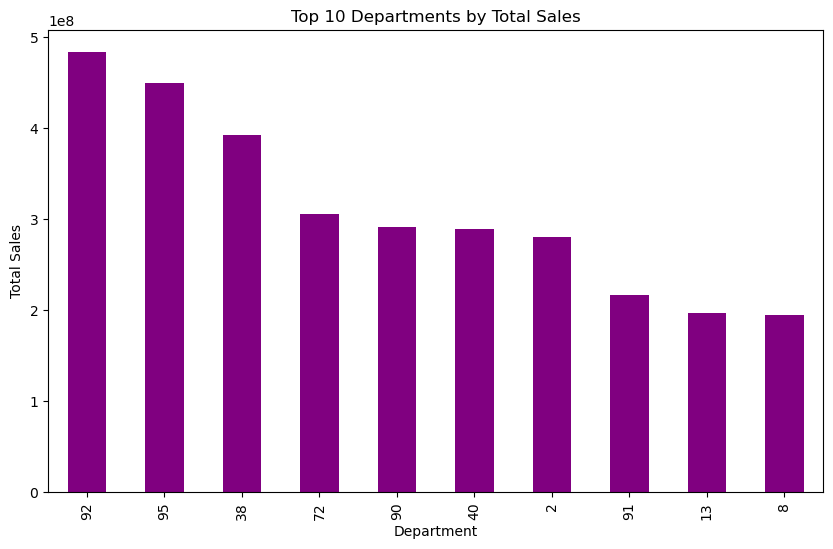

In [52]:
# Sales by store
store_sales = train_combined.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

# Bar plot for top 10 stores
plt.figure(figsize=(10, 6))
store_sales.head(10).plot(kind='bar', color='green')
plt.title('Top 10 Stores by Total Sales')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.show()

# Sales by department
dept_sales = train_combined.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)

# Bar plot for top 10 departments
plt.figure(figsize=(10, 6))
dept_sales.head(10).plot(kind='bar', color='purple')
plt.title('Top 10 Departments by Total Sales')
plt.xlabel('Department')
plt.ylabel('Total Sales')
plt.show()

## **4. Feature Engineering**  
To improve model accuracy, we engineered the following features:  
1. Extracted year, month, and week from the `Date` column.  
2. Created a binary feature to indicate holidays.  
3. Scaled numerical columns to standardize their range for machine learning.

In [53]:
train_combined['IsHolidaySeason'] = train_combined['Month'].isin([11, 12]).astype(int)
test_combined['IsHolidaySeason'] = test_combined['Month'].isin([11, 12]).astype(int)

train_combined = pd.get_dummies(train_combined, columns=['Type'], drop_first=True)
test_combined = pd.get_dummies(test_combined, columns=['Type'], drop_first=True)

missing_cols = set(train_combined.columns) - set(test_combined.columns)
for col in missing_cols:
    test_combined[col] = 0
test_combined = test_combined[train_combined.columns]


features = ['Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
            'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']

target = 'Weekly_Sales'

X = train_combined[features]
y = train_combined[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

# Fit and transform on training data, transform on testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **5. Model Training and Evaluation**  
The following models were trained on the dataset:  
1. **Linear Regression**: A simple regression model to understand baseline performance.  
2. **Decision Tree Regressor**: A tree-based model to capture non-linear relationships.  

The evaluation metrics used are:  
- Mean Absolute Error (MAE)  
- Mean Squared Error (MSE)  
- Root Mean Squared Error (RMSE)  
- R-squared (R²)

In [54]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_true, y_pred):.2f}")
    print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(y_true, y_pred):.2f}")
    print(f"R-squared (R2): {r2_score(y_true, y_pred):.2f}\n")

In [55]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)
evaluate_model(y_test, lr_predictions, "Linear Regression")

# Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_predictions = dt_model.predict(X_test_scaled)
evaluate_model(y_test, dt_predictions, "Decision Tree Regressor")

--- Linear Regression ---
Mean Absolute Error (MAE): 15075.68
Mean Squared Error (MSE): 513970778.14
Root Mean Squared Error (RMSE): 22670.92
R-squared (R2): 0.01

--- Decision Tree Regressor ---
Mean Absolute Error (MAE): 14442.24
Mean Squared Error (MSE): 482275527.27
Root Mean Squared Error (RMSE): 21960.77
R-squared (R2): 0.08



In [56]:
# Make predictions using the corrected feature set
test_combined['Predicted_Sales'] = dt_model.predict(test_combined[features])

# Save predictions to a file
test_combined[['Store', 'Dept', 'Date', 'Predicted_Sales']].to_csv('Datasets/sales_forecasting_results.csv', index=False)
print("Predictions saved to 'sales_forecasting_results.csv'")

c:\Users\adilm\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Predictions saved to 'sales_forecasting_results.csv'


## **6. Results Visualization**  
The results of the prediction models are visualized to analyze the trend.

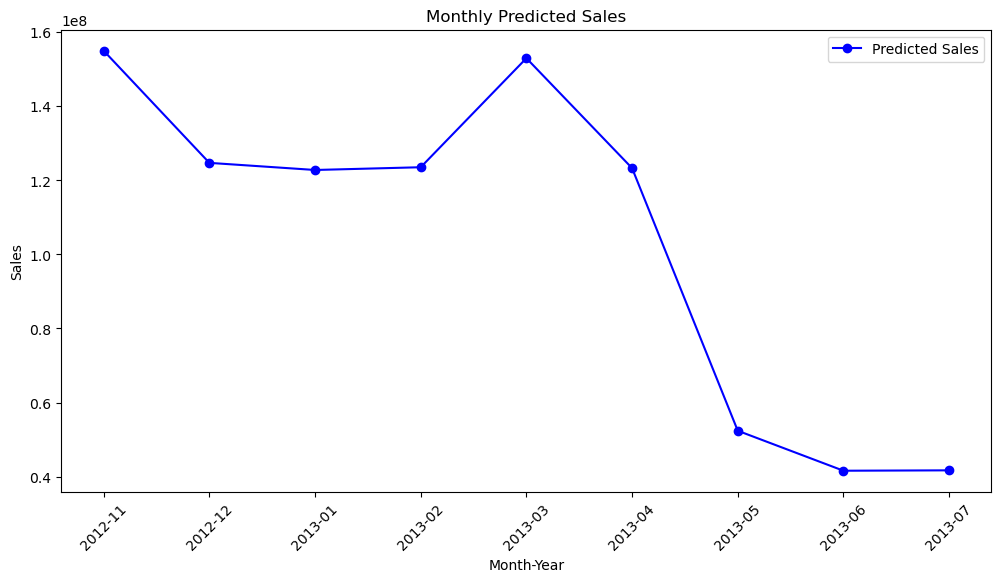

In [57]:
test_combined['Month_Year'] = test_combined['Date'].dt.to_period('M')
aggregated = test_combined.groupby('Month_Year')['Predicted_Sales'].sum().reset_index()
aggregated['Month_Year'] = aggregated['Month_Year'].astype(str)

# Plotting aggregated data
plt.figure(figsize=(12, 6))
plt.plot(aggregated['Month_Year'], aggregated['Predicted_Sales'], label='Predicted Sales', color='blue', marker='o')
plt.xticks(rotation=45)
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.title('Monthly Predicted Sales')
plt.legend()
plt.show()